In [2]:
import xgboost
# print(xgboost.__version__)

In [1]:
import pandas as pd
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("아이브1년치_참여데이터.csv")


In [3]:
df.head()

,Unnamed: 0,rpt_time_date,rpt_time_time,ads_idx,mda_idx,rpt_time_clk,rpt_time_turn,rpt_time_scost,rpt_time_acost,rpt_time_cost,rpt_time_earn
0,0,2024-07-27,0,4418,761,1,0,0,0,0,0
1,1,2024-07-27,0,7377,213,1,0,0,0,0,0
2,2,2024-07-27,0,7377,337,1,0,0,0,0,0
3,3,2024-07-27,0,7377,496,1,1,230,230,180,180
4,4,2024-07-27,0,7528,792,1,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6953146 entries, 0 to 6953145
Data columns (total 11 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   Unnamed: 0      int64 
 1   rpt_time_date   object
 2   rpt_time_time   int64 
 3   ads_idx         int64 
 4   mda_idx         int64 
 5   rpt_time_clk    int64 
 6   rpt_time_turn   int64 
 7   rpt_time_scost  int64 
 8   rpt_time_acost  int64 
 9   rpt_time_cost   int64 
 10  rpt_time_earn   int64 
dtypes: int64(10), object(1)
memory usage: 583.5+ MB


### 데이터 전처리

In [61]:
# 아이디별 행 개수 세기
id_counts = df['unique_id'].value_counts()

# # 시각화
# plt.figure(figsize=(10,6))
# id_counts.plot(kind='bar')
# plt.xlabel("unique_id")
# plt.ylabel("행 개수")
# plt.title("아이디별 행 개수 분포")
# plt.show()

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6953146 entries, 0 to 6953145
Data columns (total 12 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   Unnamed: 0      int64 
 1   rpt_time_date   object
 2   rpt_time_time   int64 
 3   ads_idx         int64 
 4   mda_idx         int64 
 5   rpt_time_clk    int64 
 6   rpt_time_turn   int64 
 7   rpt_time_scost  int64 
 8   rpt_time_acost  int64 
 9   rpt_time_cost   int64 
 10  rpt_time_earn   int64 
 11  unique_id       int64 
dtypes: int64(11), object(1)
memory usage: 636.6+ MB


In [70]:
# 2) 아이디별 마지막 날짜 구하기
last_dates = df.groupby('unique_id')['rpt_time_date'].min().reset_index()

# 3) 2025년 이전인 id만 필터링
valid_ids = last_dates[last_dates['rpt_time_date'] > "2025-05-01"]["unique_id"]

# 4) 원본 데이터에서 해당 id만 추출
filtered_df = df[df['unique_id'].isin(valid_ids)]

In [71]:
filtered_df['unique_id'].nunique()

157878

In [5]:
# 고유 ID 생성: ads_idx와 mda_idx를 결합
df["unique_id"] = (
    df["ads_idx"].astype(str).str.zfill(6) +   # ads_idx는 항상 6자리
    df["mda_idx"].astype(str).str.zfill(4)     # mda_idx는 항상 4자리
)

# 필요하다면 숫자로 변환
df["unique_id"] = df["unique_id"].astype(int)

In [6]:
df["unique_id"].nunique()

815226

In [8]:
df_time = df[["unique_id", "rpt_time_date", "rpt_time_turn"]].copy()

In [ ]:
# 주 단위로 집계
'''
주 단위 집계 월부터 시작!!
rpt_time_date = 2024-07-27 (토요일)
→ 같은 주의 월요일인 2024-07-22가 week_start가 됨
'''

df_time["rpt_time_date"] = pd.to_datetime(df_time["rpt_time_date"])

# 연도, 주차 따로 추출
iso = df_time["rpt_time_date"].dt.isocalendar()
df_time["year"] = iso.year
df_time["week"] = iso.week

# 연도-주차 키 생성
df_time["year_week"] = df_time["year"].astype(str) + "_" + df_time["week"].astype(str)

# 그룹화
df_week = (
    df_time.groupby(["unique_id", "year_week"], as_index=False)["rpt_time_turn"].sum()
    .rename(columns={"rpt_time_turn": "turn_sum"})
)

In [11]:
df_week.head()

,unique_id,year_week,turn_sum
0,25950054,2025_12,16
1,25950054,2025_13,15
2,25950054,2025_14,4
3,25950246,2024_48,0
4,25950246,2024_49,0


###  타깃값 분포 확인

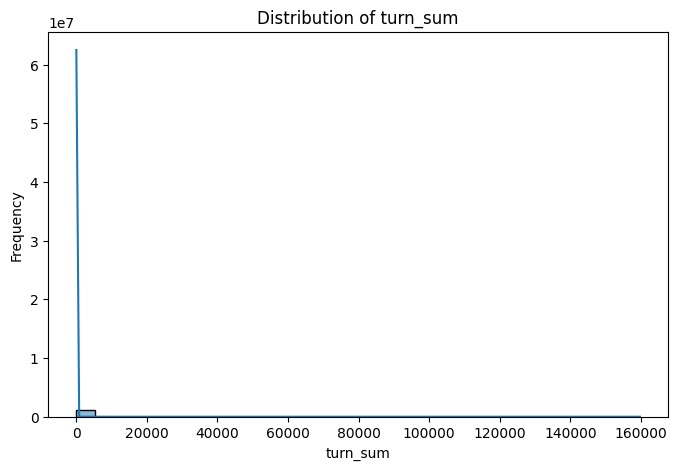

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# 히스토그램 + KDE
plt.figure(figsize=(8,5))
sns.histplot(df_week["turn_sum"], bins=30, kde=True)
plt.title("Distribution of turn_sum")
plt.xlabel("turn_sum")
plt.ylabel("Frequency")
plt.show()


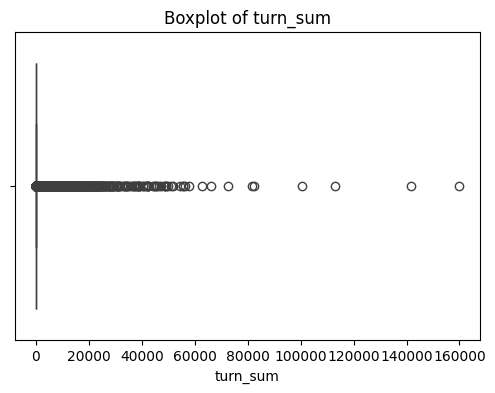

In [14]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df_week["turn_sum"])
plt.title("Boxplot of turn_sum")
plt.show()

In [15]:
(df_week["turn_sum"]==0).sum()

283717

In [16]:
zero_count = (df_week["turn_sum"] == 0).sum()
nonzero_count = (df_week["turn_sum"] > 0).sum()
zero_ratio = zero_count / len(df_week)

print(f"0인 비율: {zero_ratio:.2%} ({zero_count:,}개)")
print(f"0이 아닌 비율: {1-zero_ratio:.2%} ({nonzero_count:,}개)")

0인 비율: 26.50% (283,717개)
0이 아닌 비율: 73.50% (787,048개)


In [20]:
# 아이디별 전환수 합계
id_sum = df_week.groupby("unique_id", as_index=False)["turn_sum"].sum()

# 전환수 합계 > 0인 아이디 개수
positive_count = (id_sum["turn_sum"] > 0).sum()

# 전환수 합계 == 0인 아이디 개수
zero_count = (id_sum["turn_sum"] == 0).sum()

print("전환수 > 0인 아이디 수:", positive_count)
print("전환수 == 0인 아이디 수:", zero_count)

전환수 > 0인 아이디 수: 645107
전환수 == 0인 아이디 수: 170119


### 타깃값 로그 변환

In [21]:
import numpy as np

# turn_sum 로그 변환 (0 포함 가능) y=log(1+x)
df_week["turn_sum_log"] = np.log1p(df_week["turn_sum"])

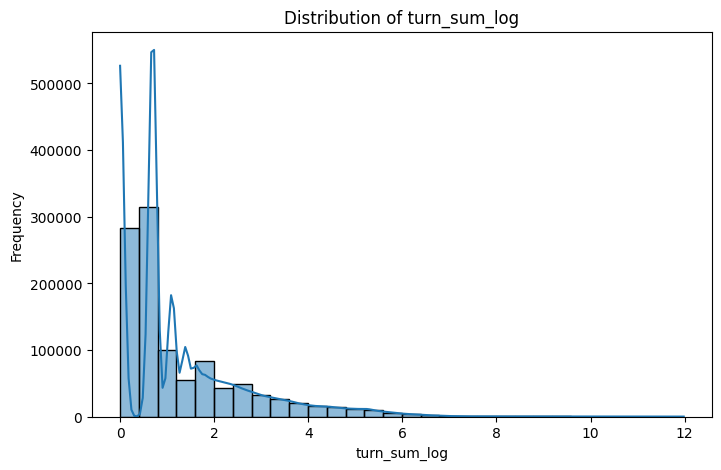

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# 히스토그램 + KDE
plt.figure(figsize=(8,5))
sns.histplot(df_week["turn_sum_log"], bins=30, kde=True)
plt.title("Distribution of turn_sum_log")
plt.xlabel("turn_sum_log")
plt.ylabel("Frequency")
plt.show()


### 글로벌 모델링 형태로 변환


In [26]:
df_week.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070765 entries, 0 to 1070764
Data columns (total 4 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   unique_id     1070765 non-null  int64  
 1   year_week     1070765 non-null  object 
 2   turn_sum      1070765 non-null  int64  
 3   turn_sum_log  1070765 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 32.7+ MB


In [27]:
df_sorted = df_week.sort_values(by=["unique_id", "year_week"]).reset_index(drop=True)

In [28]:
# 현재 year_week = "2024_1", "2024_12" 형태
# 1~9주 앞에 0을 붙여 두 자리로 만들기
df_week["year_week_num"] = df_week["year_week"].apply(lambda x: x.split("_")[0] + x.split("_")[1].zfill(2))

# 숫자형으로 변환 가능
df_week["year_week_num"] = df_week["year_week_num"].astype(int)

### 0전처리 없이 ver.

In [37]:
df_model = df_week[["unique_id", "year_week_num", "turn_sum"]].copy()

In [30]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070765 entries, 0 to 1070764
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   unique_id      1070765 non-null  int64  
 1   year_week_num  1070765 non-null  int64  
 2   turn_sum_log   1070765 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 24.5 MB


In [38]:
#데이터 나누기!!
from sklearn.metrics import mean_squared_error
import numpy as np

# 입력 변수와 타겟
X = df_model[["unique_id", "year_week_num"]]
y = df_model["turn_sum"]

# 전체 데이터에서 마지막 N%를 검증용으로 사용
split_ratio = 0.8
split_index = int(len(df_model) * split_ratio)

X_train = df_model[["unique_id", "year_week_num"]].iloc[:split_index]
y_train = df_model["turn_sum"].iloc[:split_index]

X_test = df_model[["unique_id", "year_week_num"]].iloc[split_index:]
y_test = df_model["turn_sum"].iloc[split_index:]


#### Random Forest

In [40]:
from sklearn.ensemble import RandomForestRegressor

# 랜덤포레스트 회귀 모델
rf = RandomForestRegressor()

# 학습
rf.fit(X_train, y_train)


RandomForestRegressor()

In [59]:
# 일반 평가
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 예측
y_pred = rf.predict(X_train)

# 성능 지표 계산
r2 = r2_score(y_train, y_pred)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
mae = mean_absolute_error(y_train, y_pred)

# MAPE 계산 (0 나누기 방지 위해 1e-9 더함)
mape = np.mean(np.abs((y_train - y_pred) / (y_train + 1e-9))) * 100

print(f"R^2: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

R^2: 0.9752
RMSE: 0.2453
MAE: 0.1621
MAPE: 4146935845.61%


In [41]:
# 일반 평가
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 예측
y_pred = rf.predict(X_test)

# 성능 지표 계산
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# MAPE 계산 (0 나누기 방지 위해 1e-9 더함)
mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-9))) * 100

print(f"R^2: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")


R^2: -0.0036
RMSE: 381.6105
MAE: 26.4862
MAPE: 110942548275.38%


In [36]:
# 로그 변환된 타겟을 원래 단위로 복원한 후 성능 평가
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 예측
y_pred = rf.predict(X_test)

# 로그 -> 원래 단위 복원
y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred)

# RMSE, MAE, MAPE 계산 (원래 단위)
rmse_orig = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae_orig = mean_absolute_error(y_test_original, y_pred_original)
mape_orig = np.mean(np.abs((y_test_original - y_pred_original) / (y_test_original + 1e-9))) * 100
r2_orig = r2_score(y_test_original, y_pred_original)

print(f"R^2 (original unit): {r2_orig:.4f}")
print(f"RMSE (original unit): {rmse_orig:.4f}")
print(f"MAE (original unit): {mae_orig:.4f}")
print(f"MAPE (original unit): {mape_orig:.2f}%")


R^2 (original unit): -0.0042
RMSE (original unit): 381.7146
MAE (original unit): 25.4869
MAPE (original unit): 37125928639.85%


### 0전처리 

#### 전처리만

In [42]:
# 아이디별 turn_sum 합계 계산
id_sum = df_week.groupby("unique_id")["turn_sum"].sum().reset_index()

# 합계 > 0인 아이디 필터링
valid_ids = id_sum[id_sum["turn_sum"] > 0]["unique_id"]

# df_week에서 필터링
df_zero = df_week[df_week["unique_id"].isin(valid_ids)].copy()


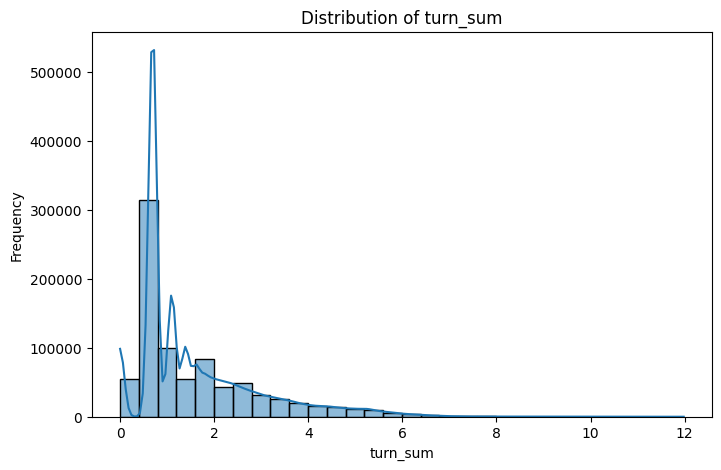

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# 히스토그램 + KDE
plt.figure(figsize=(8,5))
sns.histplot(df_zero["turn_sum"], bins=30, kde=True)
plt.title("Distribution of turn_sum")
plt.xlabel("turn_sum")
plt.ylabel("Frequency")
plt.show()


In [44]:
import numpy as np

# 로그 변환
df_zero["turn_sum_log"] = np.log1p(df_zero["turn_sum"])

# year_week_num: "2024_1" -> 202401
df_zero["year_week_num"] = df_zero["year_week"].apply(lambda x: x.split("_")[0] + x.split("_")[1].zfill(2)).astype(int)


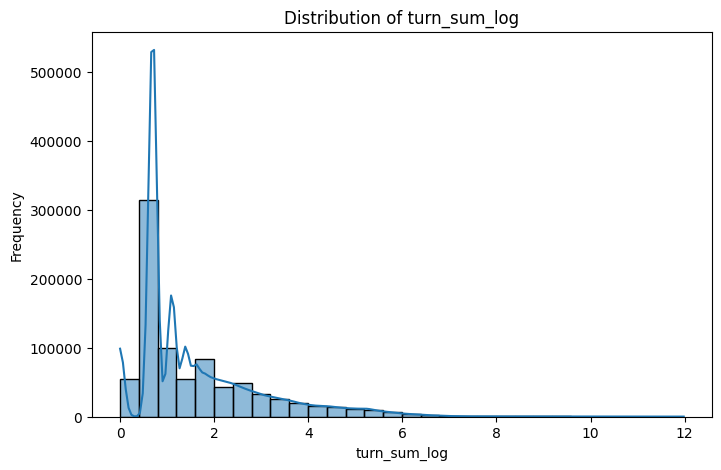

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# 히스토그램 + KDE
plt.figure(figsize=(8,5))
sns.histplot(df_zero["turn_sum_log"], bins=30, kde=True)
plt.title("Distribution of turn_sum_log")
plt.xlabel("turn_sum_log")
plt.ylabel("Frequency")
plt.show()


#### 모델링

In [47]:
df_zero.info()

<class 'pandas.core.frame.DataFrame'>
Index: 842178 entries, 0 to 1070764
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   unique_id      842178 non-null  int64  
 1   year_week      842178 non-null  object 
 2   turn_sum       842178 non-null  int64  
 3   turn_sum_log   842178 non-null  float64
 4   year_week_num  842178 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 38.6+ MB


In [48]:
df_zero_model = df_zero[["unique_id", "year_week_num", "turn_sum_log"]].copy()

In [50]:
#데이터 나누기!!
from sklearn.metrics import mean_squared_error
import numpy as np

# 입력 변수와 타겟
X = df_zero_model[["unique_id", "year_week_num"]]
y = df_zero_model["turn_sum_log"]

# 전체 데이터에서 마지막 N%를 검증용으로 사용
split_ratio = 0.8
split_index = int(len(df_zero_model) * split_ratio)

X_train = df_zero_model[["unique_id", "year_week_num"]].iloc[:split_index]
y_train = df_zero_model["turn_sum_log"].iloc[:split_index]

X_test = df_zero_model[["unique_id", "year_week_num"]].iloc[split_index:]
y_test = df_zero_model["turn_sum_log"].iloc[split_index:]


#### 랜포


In [51]:
from sklearn.ensemble import RandomForestRegressor

# 랜덤포레스트 회귀 모델
rf = RandomForestRegressor()

# 학습
rf.fit(X_train, y_train)

# 로그 변환된 타겟을 원래 단위로 복원한 후 성능 평가
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 예측
y_pred = rf.predict(X_test)

# 로그 -> 원래 단위 복원
y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred)

# RMSE, MAE, MAPE 계산 (원래 단위)
rmse_orig = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae_orig = mean_absolute_error(y_test_original, y_pred_original)
mape_orig = np.mean(np.abs((y_test_original - y_pred_original) / (y_test_original + 1e-9))) * 100
r2_orig = r2_score(y_test_original, y_pred_original)

print(f"R^2 (original unit): {r2_orig:.4f}")
print(f"RMSE (original unit): {rmse_orig:.4f}")
print(f"MAE (original unit): {mae_orig:.4f}")
print(f"MAPE (original unit): {mape_orig:.2f}%")


R^2 (original unit): -0.0058
RMSE (original unit): 430.4929
MAE (original unit): 32.6500
MAPE (original unit): 2289302636.80%


#### 레그피처 추가+랜포

In [52]:
df_model_filtered = df_zero_model.sort_values(by=["unique_id", "year_week_num"])
df_model_filtered["lag1"] = df_model_filtered.groupby("unique_id")["turn_sum_log"].shift(1)
df_model_filtered["lag2"] = df_model_filtered.groupby("unique_id")["turn_sum_log"].shift(2)
df_model_filtered["lag3"] = df_model_filtered.groupby("unique_id")["turn_sum_log"].shift(3)

# NaN 제거
df_model_filtered = df_model_filtered.dropna(subset=["lag1", "lag2", "lag3"])


In [53]:
df_model_filtered.info()    

<class 'pandas.core.frame.DataFrame'>
Index: 77632 entries, 6 to 1060611
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   unique_id      77632 non-null  int64  
 1   year_week_num  77632 non-null  int64  
 2   turn_sum_log   77632 non-null  float64
 3   lag1           77632 non-null  float64
 4   lag2           77632 non-null  float64
 5   lag3           77632 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 4.1 MB


In [55]:
#데이터 나누기!!
from sklearn.metrics import mean_squared_error
import numpy as np

# 입력 변수와 타겟
X = df_model_filtered[["unique_id", "year_week_num",'lag1','lag2','lag3']]
y = df_model_filtered["turn_sum_log"]

# 전체 데이터에서 마지막 N%를 검증용으로 사용
split_ratio = 0.8
split_index = int(len(df_model_filtered) * split_ratio)

X_train = df_model_filtered[["unique_id", "year_week_num",'lag1','lag2','lag3']].iloc[:split_index]
y_train = df_model_filtered["turn_sum_log"].iloc[:split_index]

X_test = df_model_filtered[["unique_id", "year_week_num",'lag1','lag2','lag3']].iloc[split_index:]
y_test = df_model_filtered["turn_sum_log"].iloc[split_index:]


In [56]:
from sklearn.ensemble import RandomForestRegressor

# 랜덤포레스트 회귀 모델
rf = RandomForestRegressor()

# 학습
rf.fit(X_train, y_train)

# 로그 변환된 타겟을 원래 단위로 복원한 후 성능 평가
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 예측
y_pred = rf.predict(X_test)

# 로그 -> 원래 단위 복원
y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred)

# RMSE, MAE, MAPE 계산 (원래 단위)
rmse_orig = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae_orig = mean_absolute_error(y_test_original, y_pred_original)
mape_orig = np.mean(np.abs((y_test_original - y_pred_original) / (y_test_original + 1e-9))) * 100
r2_orig = r2_score(y_test_original, y_pred_original)

print(f"R^2 (original unit): {r2_orig:.4f}")
print(f"RMSE (original unit): {rmse_orig:.4f}")
print(f"MAE (original unit): {mae_orig:.4f}")
print(f"MAPE (original unit): {mape_orig:.2f}%")


R^2 (original unit): 0.0171
RMSE (original unit): 706.8009
MAE (original unit): 32.1899
MAPE (original unit): 95295458194.16%
